In [323]:
import sys 
print(sys.version)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [324]:
import os
import copy
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
#from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from bertModel import BertClassification, dense_opt
from datasets import text_dataset, financialPhraseBankDataset
import argparse
from sklearn.metrics import f1_score

In [325]:
labels = {0:'neutral', 1:'positive',2:'negative'}
num_labels= len(labels)
vocab ="finance-uncased"
vocab_path = '/Users/svetlana/Downloads/analyst_tone-2/vocab' 
pretrained_weights_path ='/Users/svetlana/Downloads/analyst_tone-2/pretrained_weights'
fine_tuned_weight_path = '/Users/svetlana/Downloads/analyst_tone-2/fine_tuned.pth'   
max_seq_length=512
device=torch.device("cpu")

In [326]:
model = BertClassification(weight_path = pretrained_weights_path, 
                           num_labels=num_labels, vocab=vocab)

/Users/svetlana/finBERT/from git/bertModel.py:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.classifier.weight)


In [327]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30873, 768])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 768])
bert.embeddings.LayerNorm.weight 	 torch.Size([768])
bert.embeddings.LayerNorm.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight 	 torch.Size([768])
bert.encoder.layer.0.attention.outp

bert.encoder.layer.9.attention.self.query.weight 	 torch.Size([768, 768])
bert.encoder.layer.9.attention.self.query.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.self.key.weight 	 torch.Size([768, 768])
bert.encoder.layer.9.attention.self.key.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.self.value.weight 	 torch.Size([768, 768])
bert.encoder.layer.9.attention.self.value.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.output.dense.weight 	 torch.Size([768, 768])
bert.encoder.layer.9.attention.output.dense.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.output.LayerNorm.weight 	 torch.Size([768])
bert.encoder.layer.9.attention.output.LayerNorm.bias 	 torch.Size([768])
bert.encoder.layer.9.intermediate.dense.weight 	 torch.Size([3072, 768])
bert.encoder.layer.9.intermediate.dense.bias 	 torch.Size([3072])
bert.encoder.layer.9.output.dense.weight 	 torch.Size([768, 3072])
bert.encoder.layer.9.output.dense.bias 	 torch.Size([768])
bert.encoder.layer.9.ou

In [328]:
model.load_state_dict(torch.load(fine_tuned_weight_path, map_location=device))
model.to(device)

BertClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )


# 0 is neutral, 1 is positive, and 2 is negative 

In [329]:
import glob
import csv
import pandas as pd
text_path = '/Users/svetlana/Desktop/Creation/*'
files = glob.glob(text_path)

def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//75 >0:
    n = len(text1.split())//75
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:100]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*75:w*75 + 100]
      l_total.append(" ".join(l_parcial))
  return l_total

In [330]:
sentences = []
length_sent = []
for file in files:
    with open(file) as f:
        #sentence = f.read().strip().split('\n')
        sentence = f.read()
        length = len(sentence)
        length = np.log(length)
    sentences.append(sentence)
    length_sent.append(length)

In [331]:
sentences

['EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 2018-- Murphy Oil Corporation (NYSE: MUR) announced today that its wholly owned subsidiary, Murphy Exploration & Production Company - USA, has entered into a definitive agreement to form a new joint venture company with Petrobras America Inc. (“PAI”), a subsidiary of Petrobras (NYSE: PBR). The joint venture company will be comprised of Gulf of Mexico producing assets from Murphy and PAI with Murphy overseeing the operations. The transaction will have an effective date of October 1, 2018 and is expected to close by year-end 2018. \nBoth companies will contribute all their current producing Gulf of Mexico assets to the joint venture, which will be owned 80 percent by Murphy and 20 percent by PAI. The transaction excludes exploration blocks from both companies, with the exception of PAI’s blocks that hold deep exploration rights. Murphy will pay cash consideration of $900 million to PAI, subject to normal closing adjustments. Additionally, PAI 

In [332]:
import pandas as pd
df = pd.DataFrame(sentences)
df.head()

,0
0,"EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 201..."
1,﻿Archer Daniels Midland Company (NYSE: ADM) an...
2,"CHOUSTON and JOHANNESBURG, Oct. 2, 2020 /PRNew..."
3,"﻿BALTIMORE — On March 11, 2019, Barrick Gold C..."
4,"LYNCHBURG, Va.--(BUSINESS WIRE)--BWXT Medical ..."


df['text_split'] = df[0].apply(get_split)
df.head()

In [333]:
import transformers

In [334]:
from transformers import BertTokenizer

In [335]:
tokenizer = BertTokenizer(vocab_file = vocab_path, do_lower_case = True, 
                          do_basic_tokenize = True)

In [336]:
for sent in sentences:
    encoded_data = tokenizer.batch_encode_plus(
    sentences, add_special_tokens = True,
    return_attention_mask = True,
    max_length = max_seq_length,
    pad_to_max_length = True,
    return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [337]:
from torch import Tensor

In [338]:
labels = torch.empty(len(sentences), dtype=torch.long)

In [339]:
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels)

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [340]:
labels

tensor([    140415619426584,     140415619426600,     140415619426624,
                        512,                   1,     140411578661496,
            140416649635072,     140416629853912,                   0,
                      20992,          4729171088,     281470681790209,
                  134217729,   72058693549555713,     140416649469184,
            140416629853912, 6917529027641081856, 6917529027641081856,
                         12,                   0,          4729173600,
                          0,                   0,                   0,
                          0,                   0,                   0,
                          0,                   0,                   0,
                  503316480,                   0,                   0,
                          0,                   0,                   0,
                          0,                   0,                   0,
           8021715997888616,          5053567472])

In [341]:
dataset = TensorDataset(input_ids, attention_masks, labels)

In [342]:
batch_size = 32

In [343]:
dataloader = DataLoader(
    dataset, 
    sampler = SequentialSampler(dataset),
    batch_size=batch_size)

In [344]:
def predict(dataloader_):
    model.eval()
    predictions = []
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2],
                 }
        with torch.no_grad():
            outputs = model(**inputs)
        
        outputs = F.softmax(outputs,dim=1)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions.append(outputs)
        
    predictions = np.concatenate(predictions, axis = 0)
    
    return predictions

In [345]:
pred = predict(dataloader_ = dataloader)

In [346]:
len(pred)

41

In [347]:
positives = 0
negatives = 0
neutrals = 0
sentiment = []
for i in range(len(pred)):
    pred_labels_i = np.argmax(pred[i]).flatten()
    sentiment.append(pred_labels_i[0])
    if pred_labels_i[0] == 1:
        positives+=1
    elif pred_labels_i[0] == 2:
        negatives+=1
    elif pred_labels_i[0] == 0:
        neutrals+=1
print(positives, negatives, neutrals) 
print(positives / len(pred), negatives / len(pred), neutrals / len(pred))

26 0 15
0.6341463414634146 0.0 0.36585365853658536


In [348]:
df['sentiment'] = sentiment

In [349]:
df.rename(columns={0: 'text'}, inplace=True)
df.head()

,text,sentiment
0,"EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 201...",0
1,﻿Archer Daniels Midland Company (NYSE: ADM) an...,1
2,"CHOUSTON and JOHANNESBURG, Oct. 2, 2020 /PRNew...",1
3,"﻿BALTIMORE — On March 11, 2019, Barrick Gold C...",0
4,"LYNCHBURG, Va.--(BUSINESS WIRE)--BWXT Medical ...",0


In [350]:
from collections import defaultdict
groups = defaultdict(list)
roots = []
tickers = []
dates = []
for file in files:
    basename = os.path.basename(file)
    root, extension = os.path.splitext(basename)
    roots.append(root)
    for root in roots:
        ticker = str(root).split()[0]
        date = str(root).split()[1]
    tickers.append(ticker)
    dates.append(date)

In [351]:
import datetime
import timedelta

In [352]:
df['ticker'] = tickers
df['dates'] = dates

In [353]:
df['date'] = pd.to_datetime(df['dates'], format="%d%m%Y", infer_datetime_format=True)
df = df.drop(columns = ['dates'])
df

,text,sentiment,ticker,date
0,"EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 201...",0,MUR,2018-10-10
1,﻿Archer Daniels Midland Company (NYSE: ADM) an...,1,ADM,2018-10-29
2,"CHOUSTON and JOHANNESBURG, Oct. 2, 2020 /PRNew...",1,LYB,2020-10-02
3,"﻿BALTIMORE — On March 11, 2019, Barrick Gold C...",0,GOLD,2019-03-11
4,"LYNCHBURG, Va.--(BUSINESS WIRE)--BWXT Medical ...",0,BWXT,2021-03-08
5,"Infosys (NYSE: INFY), a global leader in consu...",1,INFY,2018-09-07
6,"MOORESVILLE, N.C., Aug. 24 /PRNewswire-FirstCa...",0,LOW,2009-09-24
7,SYDNEY & NEW YORK--(BUSINESS WIRE)--AMP Limite...,0,ARES,2021-02-25
8,"COLUMBIA, Md.--(BUSINESS WIRE)--Corporate Offi...",1,OFC,2020-11-02
9,"POTTSVILLE, Pa., Sept. 15, 2020 /PRNewswire/ -...",0,TAP,2020-09-15


# Adding share price data

In [354]:
from yahoo_fin import stock_info as si
from yahoo_fin.stock_info import *

In [355]:
from pandas.tseries.offsets import BDay

In [356]:
previous_dates = []
next_dates = []
for date in df.date:
    previous_date = date - BDay(1)
    previous_dates.append(previous_date)
    next_date  = date + BDay(1)
    next_dates.append(next_date)

In [357]:
df['previous_date'] = pd.to_datetime(previous_dates, format="%d%m%Y", infer_datetime_format=True)
df['next_date'] = pd.to_datetime(next_dates, format="%d%m%Y", infer_datetime_format=True)
df

,text,sentiment,ticker,date,previous_date,next_date
0,"EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 201...",0,MUR,2018-10-10,2018-10-09,2018-10-11
1,﻿Archer Daniels Midland Company (NYSE: ADM) an...,1,ADM,2018-10-29,2018-10-26,2018-10-30
2,"CHOUSTON and JOHANNESBURG, Oct. 2, 2020 /PRNew...",1,LYB,2020-10-02,2020-10-01,2020-10-05
3,"﻿BALTIMORE — On March 11, 2019, Barrick Gold C...",0,GOLD,2019-03-11,2019-03-08,2019-03-12
4,"LYNCHBURG, Va.--(BUSINESS WIRE)--BWXT Medical ...",0,BWXT,2021-03-08,2021-03-05,2021-03-09
5,"Infosys (NYSE: INFY), a global leader in consu...",1,INFY,2018-09-07,2018-09-06,2018-09-10
6,"MOORESVILLE, N.C., Aug. 24 /PRNewswire-FirstCa...",0,LOW,2009-09-24,2009-09-23,2009-09-25
7,SYDNEY & NEW YORK--(BUSINESS WIRE)--AMP Limite...,0,ARES,2021-02-25,2021-02-24,2021-02-26
8,"COLUMBIA, Md.--(BUSINESS WIRE)--Corporate Offi...",1,OFC,2020-11-02,2020-10-30,2020-11-03
9,"POTTSVILLE, Pa., Sept. 15, 2020 /PRNewswire/ -...",0,TAP,2020-09-15,2020-09-14,2020-09-16


In [358]:
percentage_list = []
for ticker, date, next_date  in zip(df.ticker, df.date, df.next_date): 
    price_data = float(si.get_data(ticker, start_date = date, 
                             end_date = date + BDay(1))['close'])
    previous_price_data = float(si.get_data(ticker, start_date = date - BDay(1), 
                             end_date = date)['close'])
    #next_price_data = float(si.get_data(ticker, start_date = next_date, 
                             #end_date = next_date + BDay(1))['close'])
    #price_change_T1 = (next_price_data / price_data) - 1
    price_change_T0 = (price_data / previous_price_data) - 1
    #percentage = "{:.0%}". format(price_change_T0)
    percentage = price_change_T0*100
    #percentage = (percentage**2)*1000
    #print(percentage)
    percentage_list.append(percentage)

In [359]:
df['%_change'] = percentage_list
df

,text,sentiment,ticker,date,previous_date,next_date,%_change
0,"EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 201...",0,MUR,2018-10-10,2018-10-09,2018-10-11,-6.283189
1,﻿Archer Daniels Midland Company (NYSE: ADM) an...,1,ADM,2018-10-29,2018-10-26,2018-10-30,1.183812
2,"CHOUSTON and JOHANNESBURG, Oct. 2, 2020 /PRNew...",1,LYB,2020-10-02,2020-10-01,2020-10-05,6.017022
3,"﻿BALTIMORE — On March 11, 2019, Barrick Gold C...",0,GOLD,2019-03-11,2019-03-08,2019-03-12,1.933488
4,"LYNCHBURG, Va.--(BUSINESS WIRE)--BWXT Medical ...",0,BWXT,2021-03-08,2021-03-05,2021-03-09,0.401676
5,"Infosys (NYSE: INFY), a global leader in consu...",1,INFY,2018-09-07,2018-09-06,2018-09-10,0.240390
6,"MOORESVILLE, N.C., Aug. 24 /PRNewswire-FirstCa...",0,LOW,2009-09-24,2009-09-23,2009-09-25,-0.650261
7,SYDNEY & NEW YORK--(BUSINESS WIRE)--AMP Limite...,0,ARES,2021-02-25,2021-02-24,2021-02-26,-1.053840
8,"COLUMBIA, Md.--(BUSINESS WIRE)--Corporate Offi...",1,OFC,2020-11-02,2020-10-30,2020-11-03,0.579577
9,"POTTSVILLE, Pa., Sept. 15, 2020 /PRNewswire/ -...",0,TAP,2020-09-15,2020-09-14,2020-09-16,-2.056548


# Adding revenues (a proxy to company's size)

In [360]:
revenues_list = []
for ticker in tickers:
    income_statement = si.get_income_statement(ticker)
    revenues = (income_statement.iloc[15][0]) / 1000000000
    revenues = np.log(revenues)
    revenues_list.append(revenues)

In [361]:
df['revenues'] = pd.DataFrame(revenues_list)
df.head()

,text,sentiment,ticker,date,previous_date,next_date,%_change,revenues
0,"EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 201...",0,MUR,2018-10-10,2018-10-09,2018-10-11,-6.283189,0.560592
1,﻿Archer Daniels Midland Company (NYSE: ADM) an...,1,ADM,2018-10-29,2018-10-26,2018-10-30,1.183812,4.164415
2,"CHOUSTON and JOHANNESBURG, Oct. 2, 2020 /PRNew...",1,LYB,2020-10-02,2020-10-01,2020-10-05,6.017022,3.323344
3,"﻿BALTIMORE — On March 11, 2019, Barrick Gold C...",0,GOLD,2019-03-11,2019-03-08,2019-03-12,1.933488,2.533300
4,"LYNCHBURG, Va.--(BUSINESS WIRE)--BWXT Medical ...",0,BWXT,2021-03-08,2021-03-05,2021-03-09,0.401676,0.753073


# Adding regression analysis

In [362]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [363]:
import statsmodels.api as sm

In [364]:
df_dummies = pd.get_dummies(df['sentiment'])
type(df)

pandas.core.frame.DataFrame

In [365]:
df2 = pd.concat([df, df_dummies], axis = 1)
df2.rename(columns={0: 'neutral_sent'}, inplace=True)
df2.rename(columns={1: 'positive_sent'}, inplace=True)
df2.columns

Index(['text', 'sentiment', 'ticker', 'date', 'previous_date', 'next_date',
       '%_change', 'revenues', 'neutral_sent', 'positive_sent'],
      dtype='object')

In [366]:
from scipy.stats import shapiro
stat, p = shapiro(df2['revenues'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.961, p=0.175
Probably Gaussian


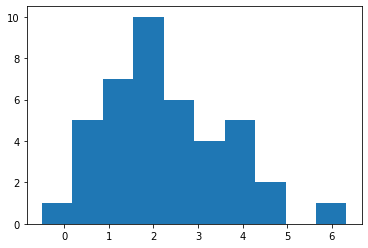

In [367]:
import matplotlib.pyplot as plt
plt.hist(df2['revenues'])
plt.show()

In [368]:
df2['length'] = length_sent

In [369]:
positive = df2[df2['sentiment']==1]
neutral = df2[df2['sentiment']==0]

In [370]:
from scipy.stats import t
from scipy.stats import norm
from scipy import stats

In [371]:
u, p_value = stats.mannwhitneyu(positive['%_change'], neutral['%_change'])
print(p_value)

0.29881954264010685


In [372]:
df2.head()

,text,sentiment,ticker,date,previous_date,next_date,%_change,revenues,neutral_sent,positive_sent,length
0,"EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 201...",0,MUR,2018-10-10,2018-10-09,2018-10-11,-6.283189,0.560592,1,0,7.969358
1,﻿Archer Daniels Midland Company (NYSE: ADM) an...,1,ADM,2018-10-29,2018-10-26,2018-10-30,1.183812,4.164415,0,1,8.376090
2,"CHOUSTON and JOHANNESBURG, Oct. 2, 2020 /PRNew...",1,LYB,2020-10-02,2020-10-01,2020-10-05,6.017022,3.323344,0,1,8.325548
3,"﻿BALTIMORE — On March 11, 2019, Barrick Gold C...",0,GOLD,2019-03-11,2019-03-08,2019-03-12,1.933488,2.533300,1,0,7.271009
4,"LYNCHBURG, Va.--(BUSINESS WIRE)--BWXT Medical ...",0,BWXT,2021-03-08,2021-03-05,2021-03-09,0.401676,0.753073,1,0,7.661056


In [373]:
stat, p = shapiro(df2['length'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.988, p=0.931
Probably Gaussian


/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


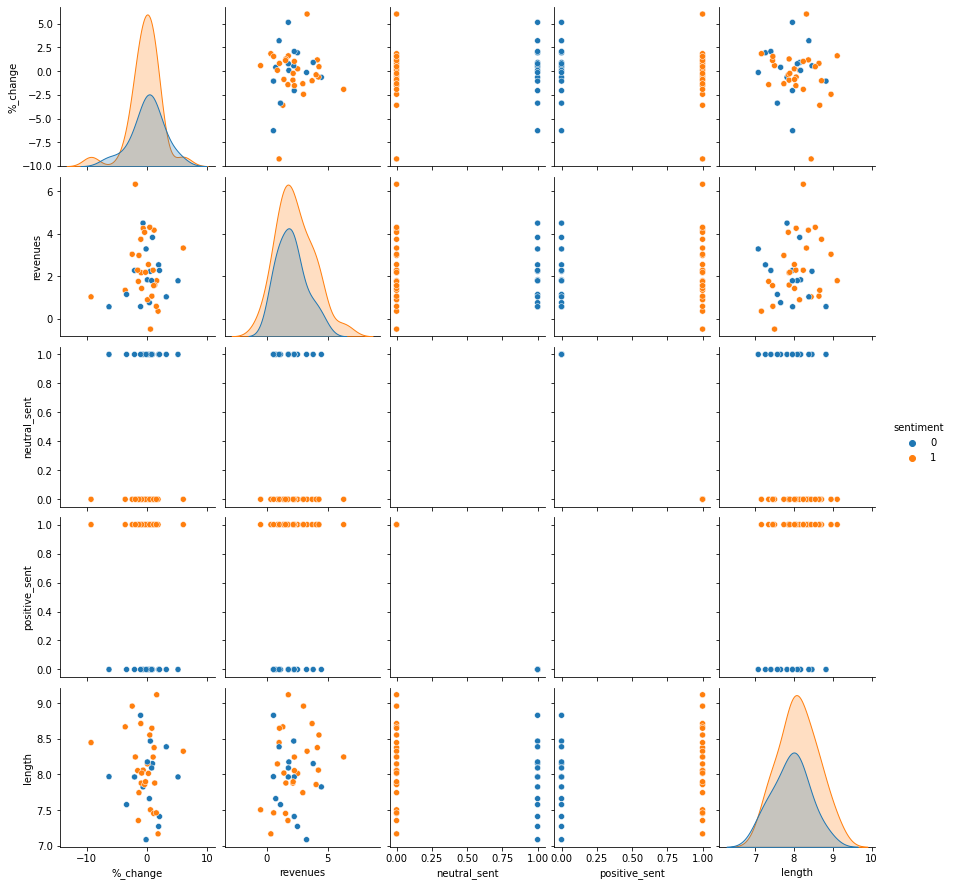

In [374]:
import seaborn as sns
fig = sns.pairplot(data=df2, hue='sentiment')
plt.show()

In [375]:
stat, p = shapiro(df2['%_change'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.912, p=0.004
Probably not Gaussian


In [376]:
price_up = df2[df2['%_change']>0]
price_down = df2[df2['%_change']<=0]

In [377]:
u, p_value = stats.mannwhitneyu(price_up['length'], price_down['length'])
print(p_value)

0.49478510536129616


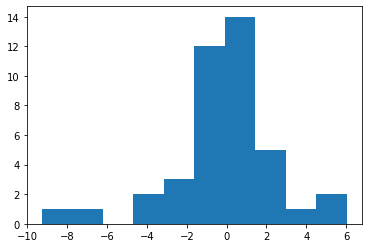

In [378]:
plt.hist(df2['%_change'])
plt.show()

<AxesSubplot:>

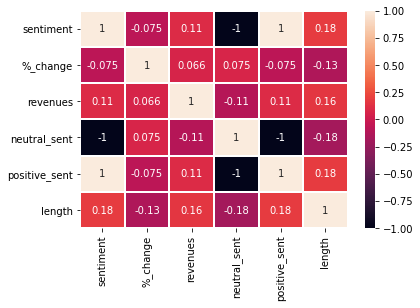

In [379]:
sns.heatmap(df2.corr(), annot = True, lw = 1)

In [380]:
X = df2[['neutral_sent', 'positive_sent', 'length', 'revenues']]
y = df2['%_change']
y = pd.to_numeric(y)

In [381]:
model = sm.OLS(y.astype(float), X.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               %_change   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.050
Method:                 Least Squares   F-statistic:                    0.3706
Date:                Wed, 10 Mar 2021   Prob (F-statistic):              0.775
Time:                        14:17:05   Log-Likelihood:                -96.312
No. Observations:                  41   AIC:                             200.6
Df Residuals:                      37   BIC:                             207.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
neutral_sent      5.5637      6.984      0.797      0.431      -8.587      19.715
positive_sent     5.2463      7.127      0.736      0.466      -9.195      19.688
length           -0.7347      0.885     -0.830      0.412      -2.529       1.059
revenues          0.1768      0.307      0.575      0.569      -0.446       0.800
==============================================================================
Omnibus:                       10.388   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.172
Skew:                          -0.679   Prob(JB):                     0.000837
Kurtosis:                       5.540   Cond. No.                         201.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""